# 객체 검출 (Object Detection)

이 노트북에서는 LiDAR 포인트 클라우드 및 카메라 이미지를 활용한 객체 검출 방법에 대해 학습하고, 다양한 객체 검출 알고리즘을 구현합니다.

## 학습 목표

- 객체 검출의 기본 개념 및 접근 방식 이해
- 포인트 클라우드 기반 클러스터링 구현
- 3D 바운딩 박스 생성 및 처리 방법 학습
- 객체 분류를 위한 기하학적 특징 추출
- 딥러닝 기반 객체 검출 방법 이해
- 센서 융합 기반 객체 검출 구현
- 객체 검출 성능 평가 방법 학습


## 1. 필요한 라이브러리 설치 및 임포트

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
from glob import glob
import open3d as o3d
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import ConvexHull
from scipy.spatial.transform import Rotation as R

# 프로젝트 루트 경로 추가
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

# 유틸리티 모듈 임포트
from utils.calibration import (
    load_calib_data,
    lidar_to_camera,
    camera_to_image,
    lidar_to_image,
    get_fov_mask
)

from utils.ground_detection import (
    ransac_ground_detection,
    extract_ground_points,
    remove_ground_points
)

from utils.object_detection import (
    euclidean_clustering,
    compute_bounding_boxes,
    compute_features,
    classify_objects,
    detect_objects
)

# 시각화 설정
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# 한글 폰트 설정 (필요한 경우)
try:
    import platform
    if platform.system() == 'Windows':
        # Windows
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif platform.system() == 'Darwin':
        # macOS
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        # Linux
        plt.rcParams['font.family'] = 'NanumGothic'
    
    # minus 기호 표시 문제 해결
    matplotlib.rcParams['axes.unicode_minus'] = False
    print("한글 폰트 설정 완료")
except:
    print("한글 폰트 설정 실패. 영문으로 표시합니다.")

한글 폰트 설정 완료


## 2. 객체 검출의 기본 개념

객체 검출은 주어진 데이터(이미지, 포인트 클라우드 등)에서 객체를 찾고 분류하는 작업입니다. 자율주행에서는 차량, 보행자, 자전거, 표지판 등 다양한 객체를 검출하고 추적해야 합니다.

### 객체 검출 접근 방식

1. **전통적인 방법**:
   - 특징 추출 및 분류기 사용 (HOG, SVM 등)
   - 클러스터링 및 기하학적 분석
   - 템플릿 매칭

2. **딥러닝 기반 방법**:
   - 2D 객체 검출: Faster R-CNN, YOLO, SSD
   - 3D 객체 검출: PointRCNN, VoxelNet, SECOND
   - 멀티모달 융합: MV3D, AVOD, MMF

3. **센서 융합 기반 방법**:
   - LiDAR와 카메라 데이터 융합
   - 멀티모달 특징 추출 및 합성
   - 센서별 결과 통합

## 3. 데이터 로드

KITTI 데이터셋에서 LiDAR 포인트 클라우드, 카메라 이미지, 캘리브레이션 파일을 로드합니다.

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


포인트 클라우드 로드 완료: (120268, 4)
이미지 로드 완료: (375, 1242, 3)
캘리브레이션 데이터 로드 완료: ['P0', 'P1', 'P2', 'P3', 'R0_rect', 'Tr_velo_to_cam', 'Tr_imu_to_velo', 'velo_to_cam_rect']
포인트 개수: 120268
X 범위: [-79.43, 77.00]
Y 범위: [-55.32, 57.72]
Z 범위: [-7.29, 2.90]
강도 범위: [0.00, 0.99]


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


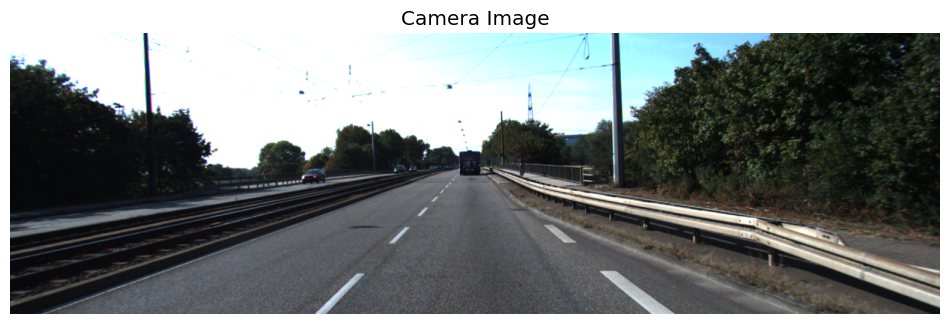

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

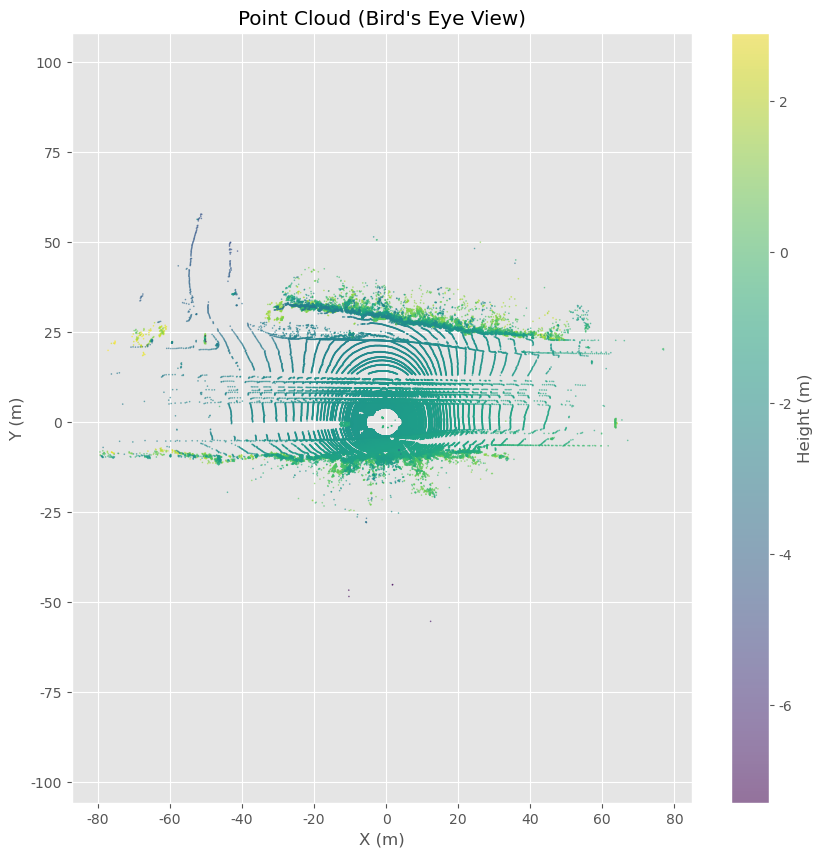

In [15]:
def load_point_cloud(bin_path):
    """
    KITTI bin 형식의 포인트 클라우드 파일 로드
    
    Args:
        bin_path (str): bin 파일 경로
        
    Returns:
        numpy.ndarray: 포인트 클라우드 [N, 4] (x, y, z, intensity)
    """
    # 이진 파일에서 4xN float 배열로 읽기
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return points

def load_image(img_path):
    """
    이미지 파일 로드
    
    Args:
        img_path (str): 이미지 파일 경로
        
    Returns:
        numpy.ndarray: RGB 이미지
    """
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    return img

def load_calib_data_safe(calib_filepath):
    """
    안전하게 캘리브레이션 데이터 로드
    
    Args:
        calib_filepath (str): 캘리브레이션 파일 경로
        
    Returns:
        dict: 캘리브레이션 데이터
    """
    try:
        return load_calib_data(calib_filepath)
    except Exception as e:
        print(f"캘리브레이션 파일 로드 중 오류: {e}")
        print("기본 캘리브레이션 데이터를 사용합니다.")
        
        # 예시 캘리브레이션 데이터
        return {
            'P2': np.array([
                [721.5377, 0.0, 609.5593, 44.85728],
                [0.0, 721.5377, 172.854, 0.2163791],
                [0.0, 0.0, 1.0, 0.002745884]
            ]),
            'R0_rect': np.eye(3),
            'Tr_velo_to_cam': np.array([
                [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
                [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
                [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
                [0.0, 0.0, 0.0, 1.0]
            ])
        }

# 데이터 경로 설정
data_dir = '/home/shbyun/KITTI/ObjectDetection/'
point_cloud_dir = os.path.join(data_dir, 'data_object_velodyne/training', 'velodyne')
image_dir = os.path.join(data_dir, 'data_object_image_2/training', 'image_2')
calib_dir = os.path.join(data_dir, 'data_object_calib/training', 'calib')

# 첫 번째 프레임 로드
# frame_id = '000000'
frame_id = '000001'
point_cloud_path = os.path.join(point_cloud_dir, f'{frame_id}.bin')
image_path = os.path.join(image_dir, f'{frame_id}.png')
calib_path = os.path.join(calib_dir, f'{frame_id}.txt')

# 데이터 로드
if os.path.exists(point_cloud_path) and os.path.exists(image_path):
    points = load_point_cloud(point_cloud_path)
    image = load_image(image_path)
    
    if os.path.exists(calib_path):
        calib_data = load_calib_data_safe(calib_path)
    else:
        print(f"캘리브레이션 파일을 찾을 수 없습니다: {calib_path}")
        # 예시 캘리브레이션 데이터 사용
        calib_data = {
            'P2': np.array([
                [721.5377, 0.0, 609.5593, 44.85728],
                [0.0, 721.5377, 172.854, 0.2163791],
                [0.0, 0.0, 1.0, 0.002745884]
            ]),
            'R0_rect': np.eye(3),
            'Tr_velo_to_cam': np.array([
                [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
                [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
                [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
                [0.0, 0.0, 0.0, 1.0]
            ])
        }
    
    print(f"포인트 클라우드 로드 완료: {points.shape}")
    print(f"이미지 로드 완료: {image.shape}")
    print(f"캘리브레이션 데이터 로드 완료: {list(calib_data.keys())}")
else:
    # 데이터가 없는 경우 예시 데이터 생성
    print("경로에 KITTI 데이터가 없습니다. 예시 데이터를 생성합니다...")
    
    # 예시 포인트 클라우드 생성
    num_points = 20000
    x = np.random.uniform(-30, 30, num_points)
    y = np.random.uniform(-30, 30, num_points)
    z = np.random.uniform(-2, 5, num_points)
    intensity = np.random.uniform(0, 1, num_points)
    points = np.column_stack((x, y, z, intensity))
    
    # 지면 점 생성
    ground_idx = np.random.choice(num_points, int(num_points*0.6), replace=False)
    points[ground_idx, 2] = -1.7 + np.random.normal(0, 0.1, len(ground_idx))
    
    # 객체 생성 (자동차, 보행자, 기타)
    # 자동차 1
    car1_center = np.array([10, 0, -0.5])
    car1_points = generate_car_points(car1_center, 100)
    # 자동차 2
    car2_center = np.array([-5, 8, -0.5])
    car2_points = generate_car_points(car2_center, 100)
    # 보행자
    ped_center = np.array([8, -5, -0.5])
    ped_points = generate_pedestrian_points(ped_center, 50)
    
    # 포인트 클라우드에 객체 추가
    points = np.vstack([points, car1_points, car2_points, ped_points])
    
    # 예시 이미지 생성 (검은 배경에 그리드)
    image = np.zeros((375, 1242, 3), dtype=np.uint8)
    for i in range(0, image.shape[0], 50):
        cv2.line(image, (0, i), (image.shape[1], i), (50, 50, 50), 1)
    for i in range(0, image.shape[1], 50):
        cv2.line(image, (i, 0), (i, image.shape[0]), (50, 50, 50), 1)
    
    # 예시 캘리브레이션 데이터
    calib_data = {
        'P2': np.array([
            [721.5377, 0.0, 609.5593, 44.85728],
            [0.0, 721.5377, 172.854, 0.2163791],
            [0.0, 0.0, 1.0, 0.002745884]
        ]),
        'R0_rect': np.eye(3),
        'Tr_velo_to_cam': np.array([
            [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
            [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
            [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01],
            [0.0, 0.0, 0.0, 1.0]
        ])
    }
    
    print(f"예시 포인트 클라우드 생성 완료: {points.shape}")
    print(f"예시 이미지 생성 완료: {image.shape}")
    print(f"예시 캘리브레이션 데이터 생성 완료")

# 포인트 클라우드 통계
print(f"포인트 개수: {points.shape[0]}")
print(f"X 범위: [{np.min(points[:, 0]):.2f}, {np.max(points[:, 0]):.2f}]")
print(f"Y 범위: [{np.min(points[:, 1]):.2f}, {np.max(points[:, 1]):.2f}]")
print(f"Z 범위: [{np.min(points[:, 2]):.2f}, {np.max(points[:, 2]):.2f}]")
print(f"강도 범위: [{np.min(points[:, 3]):.2f}, {np.max(points[:, 3]):.2f}]")

# 예시 객체 생성 함수
def generate_car_points(center, num_points):
    """
    자동차 형태의 포인트 클라우드 생성
    
    Args:
        center (numpy.ndarray): 자동차 중심 위치 [x, y, z]
        num_points (int): 생성할 포인트 수
        
    Returns:
        numpy.ndarray: 자동차 포인트 클라우드 [N, 4]
    """
    # 자동차 크기 설정
    length, width, height = 4.5, 1.8, 1.5
    
    # 무작위 포인트 생성
    x = np.random.uniform(-length/2, length/2, num_points) + center[0]
    y = np.random.uniform(-width/2, width/2, num_points) + center[1]
    z = np.random.uniform(0, height, num_points) + center[2]
    
    # 강도 값 설정
    intensity = np.random.uniform(0.5, 0.8, num_points)
    
    return np.column_stack((x, y, z, intensity))

def generate_pedestrian_points(center, num_points):
    """
    보행자 형태의 포인트 클라우드 생성
    
    Args:
        center (numpy.ndarray): 보행자 중심 위치 [x, y, z]
        num_points (int): 생성할 포인트 수
        
    Returns:
        numpy.ndarray: 보행자 포인트 클라우드 [N, 4]
    """
    # 보행자 크기 설정
    width, depth, height = 0.6, 0.6, 1.8
    
    # 무작위 포인트 생성
    x = np.random.uniform(-width/2, width/2, num_points) + center[0]
    y = np.random.uniform(-depth/2, depth/2, num_points) + center[1]
    z = np.random.uniform(0, height, num_points) + center[2]
    
    # 강도 값 설정
    intensity = np.random.uniform(0.3, 0.6, num_points)
    
    return np.column_stack((x, y, z, intensity))

# 데이터 시각화
plt.figure(figsize=(12, 4))
plt.imshow(image)
plt.title('Camera Image')
plt.axis('off')
plt.show()

# 포인트 클라우드 시각화 (BEV)
plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=points[:, 2], cmap='viridis', s=0.5, alpha=0.5)
plt.colorbar(label='Height (m)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Point Cloud (Bird\'s Eye View)')
plt.axis('equal')
plt.grid(True)
plt.show()


## 4. 지면 검출 및 제거

객체 검출의 전처리 단계로 지면 포인트를 검출하고 제거합니다.

전체 포인트 개수: 120268
지면 포인트 개수: 70150
지면 포인트 비율: 58.33%
지면 방정식: 0.0167x + -0.0167y + -0.9997z + -1.6745 = 0
비지면 포인트 개수: 50118


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

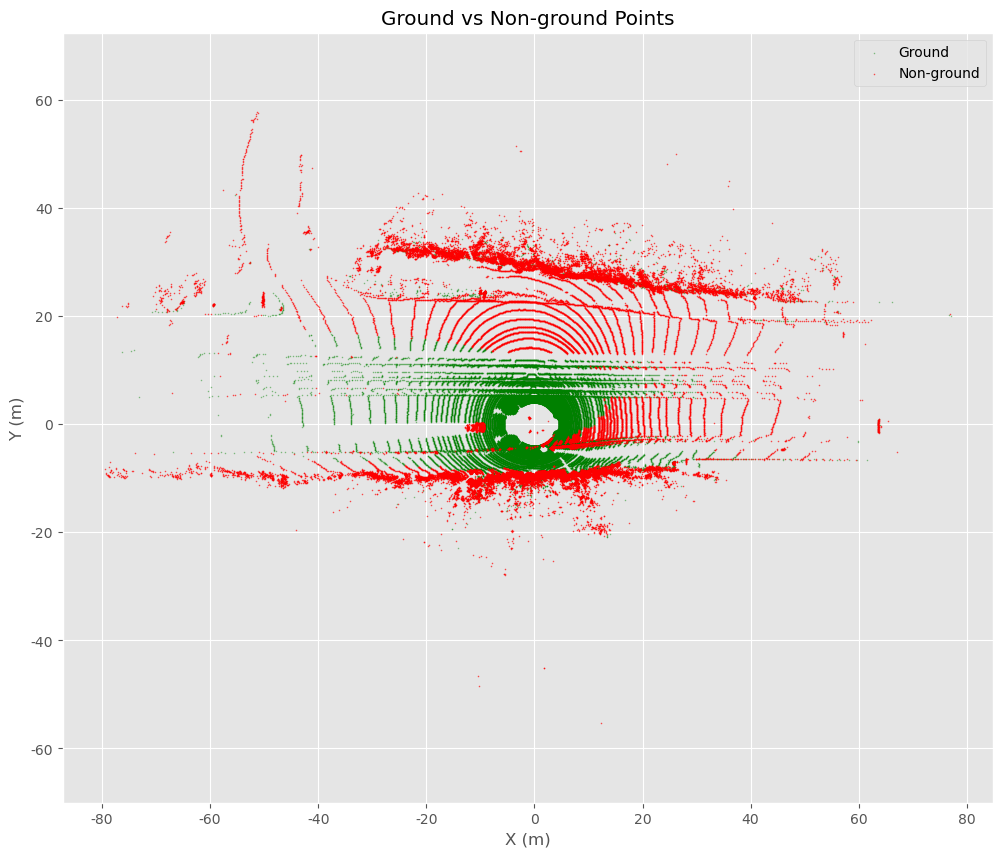

In [16]:
# RANSAC 기반 지면 검출
distance_thresh = 0.2  # 인라이어로 간주하는 평면과의 최대 거리 (m)
max_iterations = 100   # RANSAC 최대 반복 횟수

# 지면 검출
ground_mask, ground_model = ransac_ground_detection(
    points, distance_thresh=distance_thresh, 
    max_iterations=max_iterations, return_model=True
)

# 결과 출력
print(f"전체 포인트 개수: {points.shape[0]}")
print(f"지면 포인트 개수: {np.sum(ground_mask)}")
print(f"지면 포인트 비율: {np.sum(ground_mask) / points.shape[0] * 100:.2f}%")
print(f"지면 방정식: {ground_model['normal'][0]:.4f}x + {ground_model['normal'][1]:.4f}y + {ground_model['normal'][2]:.4f}z + {ground_model['intercept']:.4f} = 0")

# 지면 제거
non_ground_points = remove_ground_points(points, ground_mask)
print(f"비지면 포인트 개수: {non_ground_points.shape[0]}")

# 시각화 (지면/비지면 구분)
plt.figure(figsize=(12, 10))

# 지면 포인트
ground_points = extract_ground_points(points, ground_mask)
plt.scatter(ground_points[:, 0], ground_points[:, 1], c='green', s=0.5, alpha=0.3, label='Ground')

# 비지면 포인트
plt.scatter(non_ground_points[:, 0], non_ground_points[:, 1], c='red', s=0.5, alpha=0.5, label='Non-ground')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Ground vs Non-ground Points')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

## 5. 포인트 클라우드 클러스터링

비지면 포인트를 클러스터링하여 객체 후보를 검출합니다.


In [17]:
# DBSCAN 클러스터링
def dbscan_clustering(points, eps=0.5, min_samples=10, max_points=10000):
    """
    DBSCAN 알고리즘을 사용한 클러스터링
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        eps (float): 이웃 포인트 판단 거리 임계값
        min_samples (int): 핵심 포인트 판단을 위한 최소 이웃 수
        max_points (int): 클러스터 최대 포인트 수
        
    Returns:
        tuple: (클러스터 리스트, 레이블)
    """
    # DBSCAN 클러스터링 적용
    db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(points[:, :3])
    labels = db.labels_
    
    # 클러스터 개수 (-1은 노이즈)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"검출된 클러스터 수: {n_clusters}")
    
    # 각 클러스터 추출
    clusters = []
    for i in range(n_clusters):
        cluster_points = points[labels == i]
        
        # 너무 큰 클러스터는 필터링 (지면 잔여물일 가능성)
        if len(cluster_points) <= max_points:
            clusters.append(cluster_points)
    
    return clusters, labels

# Open3D를 사용한 클러스터링 시각화
def visualize_clusters_o3d(points, labels):
    """
    클러스터링 결과 시각화 (Open3D)
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        labels (numpy.ndarray): 클러스터 레이블 [N]
        
    Returns:
        None
    """
    # 포인트 클라우드 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    
    # 색상 설정
    max_label = labels.max()
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    
    # 노이즈 포인트는 검은색으로 설정
    colors[labels < 0] = [0, 0, 0, 1]
    
    # RGB 컬럼만 사용
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    
    # 시각화
    try:
        o3d.visualization.draw_geometries([pcd])
    except:
        print("Open3D 시각화 실패. 대체 시각화 방법을 사용합니다.")
        # 대체 시각화 (Matplotlib)
        visualize_clusters_matplotlib(points, labels)

# Matplotlib을 사용한 클러스터링 시각화 (대안)
def visualize_clusters_matplotlib(points, labels):
    """
    클러스터링 결과 시각화 (Matplotlib)
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        labels (numpy.ndarray): 클러스터 레이블 [N]
        
    Returns:
        None
    """
    # BEV 시각화
    plt.figure(figsize=(12, 10))
    
    # 노이즈 포인트 (레이블 -1)
    noise_points = points[labels == -1]
    plt.scatter(noise_points[:, 0], noise_points[:, 1], c='black', s=0.5, alpha=0.5, label='Noise')
    
    # 클러스터 포인트
    unique_labels = set(labels)
    unique_labels.discard(-1)  # 노이즈 레이블 제외
    
    # 색상 맵
    cmap = plt.get_cmap("tab20")
    colors = cmap(np.linspace(0, 1, len(unique_labels)))
    
    # 각 클러스터 그리기
    for i, label in enumerate(unique_labels):
        cluster_points = points[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[i]], s=0.5, alpha=0.8, label=f'Cluster {label}')
    
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Point Cloud Clustering Results')
    plt.axis('equal')
    plt.grid(True)
    
    # 범례는 너무 많은 클러스터가 있으면 생략
    if len(unique_labels) <= 20:
        plt.legend()
    
    plt.show()
    
    # 3D 시각화 (샘플링된 포인트)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 노이즈 포인트 (샘플링)
    if len(noise_points) > 0:
        sample_size = min(1000, len(noise_points))
        sampled_noise = noise_points[np.random.choice(len(noise_points), sample_size, replace=False)]
        ax.scatter(sampled_noise[:, 0], sampled_noise[:, 1], sampled_noise[:, 2], 
                  c='black', s=1, alpha=0.5, label='Noise')
    
    # 각 클러스터 그리기 (샘플링)
    for i, label in enumerate(unique_labels):
        cluster_points = points[labels == label]
        sample_size = min(100, len(cluster_points))
        sampled_cluster = cluster_points[np.random.choice(len(cluster_points), sample_size, replace=False)]
        ax.scatter(sampled_cluster[:, 0], sampled_cluster[:, 1], sampled_cluster[:, 2], 
                  c=[colors[i]], s=2, alpha=0.8, label=f'Cluster {label}')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D Point Cloud Clustering')
    
    plt.tight_layout()
    plt.show()

# 비지면 포인트에 대해 클러스터링 수행
eps = 0.5  # 클러스터링 거리 임계값
min_samples = 10  # 최소 포인트 수
max_points = 5000  # 최대 클러스터 크기

clusters, labels = dbscan_clustering(non_ground_points, eps, min_samples, max_points)

print(f"유효한 클러스터 수: {len(clusters)}")
for i, cluster in enumerate(clusters):
    print(f"클러스터 {i}: {len(cluster)} 포인트")

# 클러스터링 결과 시각화
try:
    visualize_clusters_o3d(non_ground_points, labels)
except:
    visualize_clusters_matplotlib(non_ground_points, labels)

검출된 클러스터 수: 200
유효한 클러스터 수: 199
클러스터 0: 20 포인트
클러스터 1: 20 포인트
클러스터 2: 11 포인트
클러스터 3: 61 포인트
클러스터 4: 25 포인트
클러스터 5: 815 포인트
클러스터 6: 29 포인트
클러스터 7: 4857 포인트
클러스터 8: 60 포인트
클러스터 9: 163 포인트
클러스터 10: 10 포인트
클러스터 11: 197 포인트
클러스터 12: 19 포인트
클러스터 13: 1080 포인트
클러스터 14: 17 포인트
클러스터 15: 37 포인트
클러스터 16: 12 포인트
클러스터 17: 830 포인트
클러스터 18: 1686 포인트
클러스터 19: 622 포인트
클러스터 20: 93 포인트
클러스터 21: 45 포인트
클러스터 22: 17 포인트
클러스터 23: 15 포인트
클러스터 24: 93 포인트
클러스터 25: 12 포인트
클러스터 26: 560 포인트
클러스터 27: 35 포인트
클러스터 28: 13 포인트
클러스터 29: 11 포인트
클러스터 30: 11 포인트
클러스터 31: 12 포인트
클러스터 32: 10 포인트
클러스터 33: 15 포인트
클러스터 34: 11 포인트
클러스터 35: 10 포인트
클러스터 36: 150 포인트
클러스터 37: 14 포인트
클러스터 38: 11 포인트
클러스터 39: 50 포인트
클러스터 40: 12 포인트
클러스터 41: 11 포인트
클러스터 42: 19 포인트
클러스터 43: 16 포인트
클러스터 44: 10 포인트
클러스터 45: 71 포인트
클러스터 46: 12 포인트
클러스터 47: 41 포인트
클러스터 48: 19 포인트
클러스터 49: 11 포인트
클러스터 50: 13 포인트
클러스터 51: 42 포인트
클러스터 52: 12 포인트
클러스터 53: 10 포인트
클러스터 54: 56 포인트
클러스터 55: 125 포인트
클러스터 56: 15 포인트
클러스터 57: 16 포인트
클러스터 58: 39 포인트
클러스터 59: 73 포인트
클러스터

## 6. 3D 바운딩 박스 생성

클러스터링된 객체에 대해 3D 바운딩 박스를 생성합니다.

In [18]:
def compute_3d_bounding_box(points, oriented=True):
    """
    3D 바운딩 박스 계산
    
    Args:
        points (numpy.ndarray): 객체 포인트 클라우드 [N, 3+]
        oriented (bool): 방향성 바운딩 박스 여부
        
    Returns:
        dict: 바운딩 박스 정보
    """
    # 방향성 바운딩 박스
    if oriented:
        # 주성분 분석 (PCA)으로 객체 방향 계산
        points_centered = points[:, :3] - np.mean(points[:, :3], axis=0)
        cov = np.cov(points_centered.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        
        # 고유값 순서대로 정렬 (오름차순)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # 방향 벡터와 크기 계산
        axes = eigenvectors
        
        # 회전된 좌표계에서 포인트 표현
        points_rotated = np.dot(points_centered, axes)
        
        # 회전된 좌표계에서 축 정렬 바운딩 박스 계산
        min_bounds = np.min(points_rotated, axis=0)
        max_bounds = np.max(points_rotated, axis=0)
        
        # 바운딩 박스 크기
        dimensions = max_bounds - min_bounds
        
        # 중심점 계산
        center = np.mean(points[:, :3], axis=0)
        
        # 회전 행렬
        rotation_matrix = axes
        
        # 바운딩 박스 정보
        bbox = {
            'center': center,
            'dimensions': dimensions,
            'rotation_matrix': rotation_matrix,
            'min_bounds_rotated': min_bounds,
            'max_bounds_rotated': max_bounds
        }
    else:
        # 축 정렬 바운딩 박스
        min_bounds = np.min(points[:, :3], axis=0)
        max_bounds = np.max(points[:, :3], axis=0)
        
        # 바운딩 박스 크기와 중심점
        dimensions = max_bounds - min_bounds
        center = (min_bounds + max_bounds) / 2
        
        # 바운딩 박스 정보
        bbox = {
            'center': center,
            'dimensions': dimensions,
            'min_bounds': min_bounds,
            'max_bounds': max_bounds
        }
    
    return bbox

def visualize_3d_bounding_boxes(points, bboxes, colors=None):
    """
    3D 바운딩 박스 시각화
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        bboxes (list): 바운딩 박스 리스트
        colors (list, optional): 바운딩 박스별 색상
        
    Returns:
        None
    """
    # 기본 색상 설정
    if colors is None:
        cmap = plt.get_cmap("tab10")
        colors = cmap(np.linspace(0, 1, len(bboxes)))
    
    # Open3D 포인트 클라우드 생성
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    
    # 회색으로 포인트 색상 설정
    pcd.colors = o3d.utility.Vector3dVector(np.ones((len(points), 3)) * 0.5)
    
    # 시각화 객체 리스트
    geometries = [pcd]
    
    # 각 바운딩 박스 추가
    for i, bbox in enumerate(bboxes):
        center = bbox['center']
        dimensions = bbox['dimensions']
        
        # 방향성 바운딩 박스
        if 'rotation_matrix' in bbox:
            R = bbox['rotation_matrix']
            
            # Open3D 방향성 바운딩 박스 객체
            o3d_bbox = o3d.geometry.OrientedBoundingBox(
                center=center,
                R=R,
                extent=dimensions
            )
        else:
            # 축 정렬 바운딩 박스
            min_bound = bbox['min_bounds']
            max_bound = bbox['max_bounds']
            
            # Open3D 축 정렬 바운딩 박스 객체
            o3d_bbox = o3d.geometry.AxisAlignedBoundingBox(
                min_bound=min_bound,
                max_bound=max_bound
            )
        
        # 바운딩 박스 색상 설정
        o3d_bbox.color = colors[i][:3]
        
        # 시각화 객체 리스트에 추가
        geometries.append(o3d_bbox)
    
    # 시각화
    try:
        o3d.visualization.draw_geometries(geometries)
    except:
        print("Open3D 시각화 실패. 대체 시각화 방법을 사용합니다.")
        visualize_bboxes_matplotlib(points, bboxes, colors)

def visualize_bboxes_matplotlib(points, bboxes, colors=None):
    """
    Matplotlib을 사용한 3D 바운딩 박스 시각화 (대안)
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        bboxes (list): 바운딩 박스 리스트
        colors (list, optional): 바운딩 박스별 색상
        
    Returns:
        None
    """
    # 기본 색상 설정
    if colors is None:
        cmap = plt.get_cmap("tab10")
        colors = cmap(np.linspace(0, 1, len(bboxes)))
    
    # BEV 시각화
    plt.figure(figsize=(12, 10))
    
    # 포인트 클라우드 그리기 (흐리게)
    plt.scatter(points[:, 0], points[:, 1], c='gray', s=0.5, alpha=0.3)
    
    # 각 바운딩 박스 그리기
    for i, bbox in enumerate(bboxes):
        center = bbox['center']
        dimensions = bbox['dimensions']
        
        if 'rotation_matrix' in bbox:
            # 방향성 바운딩 박스
            R = bbox['rotation_matrix']
            
            # 바운딩 박스의 4개 코너 계산 (바닥면)
            l, w = dimensions[0], dimensions[1]
            corners_local = np.array([
                [ l/2,  w/2],
                [ l/2, -w/2],
                [-l/2, -w/2],
                [-l/2,  w/2],
                [ l/2,  w/2]  # 처음 점과 연결
            ])
            
            # 회전 적용
            R_2d = R[:2, :2]
            corners_global = np.dot(corners_local, R_2d.T) + center[:2]
            
            # 바운딩 박스 그리기
            plt.plot(corners_global[:, 0], corners_global[:, 1], '-', 
                     color=colors[i][:3], linewidth=2, label=f'Box {i}')
            
            # 방향성 표시
            front_center = center[:2] + R[:2, 0] * dimensions[0] / 2
            plt.arrow(center[0], center[1], 
                      front_center[0] - center[0], front_center[1] - center[1], 
                      head_width=0.5, head_length=0.7, fc=colors[i][:3], ec=colors[i][:3])
        else:
            # 축 정렬 바운딩 박스
            l, w = dimensions[0], dimensions[1]
            
            # 사각형 그리기
            min_x, min_y = center[0] - l/2, center[1] - w/2
            rect = plt.Rectangle((min_x, min_y), l, w, 
                                 fill=False, edgecolor=colors[i][:3], linewidth=2, label=f'Box {i}')
            plt.gca().add_patch(rect)
    
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Point Cloud with 3D Bounding Boxes (BEV)')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 3D 시각화 (샘플링된 포인트)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 포인트 클라우드 샘플링
    sample_size = min(2000, len(points))
    sampled_points = points[np.random.choice(len(points), sample_size, replace=False)]
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], 
              c='gray', s=1, alpha=0.5)
    
    # 각 바운딩 박스의 8개 코너 그리기
    for i, bbox in enumerate(bboxes):
        center = bbox['center']
        dimensions = bbox['dimensions']
        
        if 'rotation_matrix' in bbox:
            # 방향성 바운딩 박스
            R = bbox['rotation_matrix']
        else:
            # 축 정렬 바운딩 박스
            R = np.eye(3)
        
        # 박스의 8개 코너 계산
        l, w, h = dimensions
        corners_local = np.array([
            [ l/2,  w/2,  h/2],  # 0: 오른쪽 위 앞
            [ l/2, -w/2,  h/2],  # 1: 왼쪽 위 앞
            [-l/2, -w/2,  h/2],  # 2: 왼쪽 위 뒤
            [-l/2,  w/2,  h/2],  # 3: 오른쪽 위 뒤
            [ l/2,  w/2, -h/2],  # 4: 오른쪽 아래 앞
            [ l/2, -w/2, -h/2],  # 5: 왼쪽 아래 앞
            [-l/2, -w/2, -h/2],  # 6: 왼쪽 아래 뒤
            [-l/2,  w/2, -h/2]   # 7: 오른쪽 아래 뒤
        ])
        
        # 회전 및 이동 적용
        corners_global = np.dot(corners_local, R.T) + center
        
        # 바닥면
        for i, j in [(4, 5), (5, 6), (6, 7), (7, 4)]:
            ax.plot([corners_global[i, 0], corners_global[j, 0]],
                    [corners_global[i, 1], corners_global[j, 1]],
                    [corners_global[i, 2], corners_global[j, 2]], 
                    c=colors[i][:3], linewidth=2)
        
        # 천장면
        for i, j in [(0, 1), (1, 2), (2, 3), (3, 0)]:
            ax.plot([corners_global[i, 0], corners_global[j, 0]],
                    [corners_global[i, 1], corners_global[j, 1]],
                    [corners_global[i, 2], corners_global[j, 2]], 
                    c=colors[i][:3], linewidth=2)
        
        # 기둥
        for i, j in [(0, 4), (1, 5), (2, 6), (3, 7)]:
            ax.plot([corners_global[i, 0], corners_global[j, 0]],
                    [corners_global[i, 1], corners_global[j, 1]],
                    [corners_global[i, 2], corners_global[j, 2]], 
                    c=colors[i][:3], linewidth=2)
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('3D Bounding Boxes')
    
    plt.tight_layout()
    plt.show()

# 클러스터에 대해 3D 바운딩 박스 생성
bboxes = []
for cluster in clusters:
    bbox = compute_3d_bounding_box(cluster, oriented=True)
    bboxes.append(bbox)

print(f"생성된 바운딩 박스 수: {len(bboxes)}")
for i, bbox in enumerate(bboxes):
    center = bbox['center']
    dimensions = bbox['dimensions']
    print(f"박스 {i}: 중심=({center[0]:.2f}, {center[1]:.2f}, {center[2]:.2f}), "
          f"크기=({dimensions[0]:.2f}, {dimensions[1]:.2f}, {dimensions[2]:.2f})")

# 바운딩 박스 시각화
try:
    visualize_3d_bounding_boxes(non_ground_points, bboxes)
except:
    visualize_bboxes_matplotlib(non_ground_points, bboxes)

생성된 바운딩 박스 수: 199
박스 0: 중심=(45.50, 23.29, 1.66), 크기=(1.28, 0.98, 0.63)
박스 1: 중심=(36.85, 24.09, 1.43), 크기=(1.23, 0.80, 0.35)
박스 2: 중심=(32.65, 24.38, 1.48), 크기=(0.70, 0.72, 0.52)
박스 3: 중심=(31.78, 25.05, 0.93), 크기=(1.99, 1.53, 1.31)
박스 4: 중심=(30.54, 25.73, 1.30), 크기=(1.31, 0.72, 0.59)
박스 5: 중심=(23.22, 25.72, -0.12), 크기=(12.06, 4.14, 3.44)
박스 6: 중심=(20.66, 25.76, 1.15), 크기=(1.44, 1.00, 0.41)
박스 7: 중심=(4.43, 28.59, -0.52), 크기=(30.65, 8.32, 4.41)
박스 8: 중심=(13.10, 26.73, 1.00), 크기=(1.70, 0.95, 0.51)
박스 9: 중심=(-10.64, 31.67, 0.42), 크기=(3.91, 2.19, 1.33)
박스 10: 중심=(-11.80, 32.79, 1.32), 크기=(0.59, 0.44, 0.33)
박스 11: 중심=(-9.50, 24.25, -0.47), 크기=(3.29, 1.46, 1.71)
박스 12: 중심=(-13.90, 30.90, 1.28), 크기=(1.34, 0.67, 0.27)
박스 13: 중심=(-17.53, 31.74, -0.44), 크기=(11.47, 4.85, 3.19)
박스 14: 중심=(-22.72, 32.31, 1.40), 크기=(1.33, 0.64, 0.50)
박스 15: 중심=(-28.92, 28.70, 1.22), 크기=(1.27, 1.09, 0.68)
박스 16: 중심=(-37.26, -9.50, 1.35), 크기=(0.76, 0.80, 0.32)
박스 17: 중심=(-27.07, -9.84, -0.32), 크기=(9.61, 3.43, 3.07)
박스 18

## 7. 객체 분류

클러스터링된 객체에 대해 기하학적 특성을 기반으로 객체 분류를 수행합니다.

In [19]:
def extract_geometric_features(cluster, bbox):
    """
    객체의 기하학적 특징 추출
    
    Args:
        cluster (numpy.ndarray): 클러스터 포인트 [N, 3+]
        bbox (dict): 바운딩 박스 정보
        
    Returns:
        numpy.ndarray: 특징 벡터
    """
    center = bbox['center']
    dimensions = bbox['dimensions']
    
    # 길이, 폭, 높이
    l, w, h = dimensions
    
    # 1. 크기 관련 특징
    volume = l * w * h
    surface_area = 2 * (l*w + l*h + w*h)
    compactness = surface_area / (36 * np.pi * volume**(2/3))  # 구에 대해 최소화됨
    
    # 2. 형태 관련 특징
    length_width_ratio = l / max(w, 1e-6)
    height_length_ratio = h / max(l, 1e-6)
    height_width_ratio = h / max(w, 1e-6)
    elongation = max(l, w) / min(l, w)
    
    # 3. 포인트 분포 관련 특징
    point_density = len(cluster) / volume
    
    # 4. 상대적 위치 관련 특징
    distance_to_origin = np.linalg.norm(center)
    height_from_ground = center[2]  # z 좌표
    
    # 5. 고유값 기반 특징
    if 'rotation_matrix' in bbox:
        # 이미 PCA 결과를 가지고 있음
        eigenvalues = dimensions**2 / 4  # 간단한 추정
    else:
        # PCA 계산
        points_centered = cluster[:, :3] - np.mean(cluster[:, :3], axis=0)
        cov = np.cov(points_centered.T)
        eigenvalues, _ = np.linalg.eigh(cov)
        eigenvalues = eigenvalues[::-1]  # 내림차순 정렬
    
    # 고유값 기반 특징
    linearity = (eigenvalues[0] - eigenvalues[1]) / max(eigenvalues[0], 1e-6)
    planarity = (eigenvalues[1] - eigenvalues[2]) / max(eigenvalues[0], 1e-6)
    sphericity = eigenvalues[2] / max(eigenvalues[0], 1e-6)
    
    # 6. 강도 관련 특징 (있는 경우)
    if cluster.shape[1] >= 4:
        mean_intensity = np.mean(cluster[:, 3])
        std_intensity = np.std(cluster[:, 3])
    else:
        mean_intensity = 0
        std_intensity = 0
    
    # 모든 특징을 하나의 벡터로 결합
    features = np.array([
        l, w, h,                             # 크기
        volume, surface_area, compactness,   # 크기 관련
        length_width_ratio, height_length_ratio, height_width_ratio, elongation,  # 형태
        point_density,                       # 포인트 분포
        distance_to_origin, height_from_ground,  # 위치
        linearity, planarity, sphericity,    # 고유값 기반
        mean_intensity, std_intensity        # 강도 관련
    ])
    
    return features

def classify_object(features):
    """
    특징 벡터를 기반으로 객체 분류
    
    Args:
        features (numpy.ndarray): 특징 벡터
        
    Returns:
        tuple: (클래스, 신뢰도)
    """
    # 특징 추출
    l, w, h = features[:3]
    volume = features[3]
    length_width_ratio = features[6]
    height_length_ratio = features[7]
    height_width_ratio = features[8]
    point_density = features[10]
    height_from_ground = features[12]
    
    # 간단한 규칙 기반 분류
    confidence = 0.0
    
    # 차량 (자동차, 트럭 등)
    if 3.0 < l < 12.0 and 1.5 < w < 3.5 and 1.0 < h < 3.5:
        if l > 6.0 and h > 2.5:
            # 트럭/버스
            obj_class = 'truck'
            confidence = 0.7
        else:
            # 자동차
            obj_class = 'car'
            confidence = 0.8
    
    # 보행자
    elif 0.4 < l < 1.0 and 0.4 < w < 1.0 and 1.4 < h < 2.2:
        if height_width_ratio > 2.0 and height_length_ratio > 2.0:
            obj_class = 'pedestrian'
            confidence = 0.7
        else:
            obj_class = 'small_object'
            confidence = 0.5
    
    # 자전거/이륜차
    elif 1.0 < l < 2.5 and 0.4 < w < 1.0 and 1.0 < h < 2.0:
        if length_width_ratio > 1.5:
            obj_class = 'cyclist'
            confidence = 0.6
        else:
            obj_class = 'small_object'
            confidence = 0.5
    
    # 표지판, 전봇대 등 수직 구조물
    elif h > 2.0 and l < 1.0 and w < 1.0:
        obj_class = 'pole'
        confidence = 0.6
    
    # 기타 장애물
    else:
        obj_class = 'unknown'
        confidence = 0.5
    
    return obj_class, confidence

# 각 클러스터에 대해 특징 추출 및 분류 수행
object_results = []

for i, (cluster, bbox) in enumerate(zip(clusters, bboxes)):
    # 특징 추출
    features = extract_geometric_features(cluster, bbox)
    
    # 객체 분류
    obj_class, confidence = classify_object(features)
    
    # 결과 저장
    result = {
        'id': i,
        'class': obj_class,
        'confidence': confidence,
        'center': bbox['center'],
        'dimensions': bbox['dimensions'],
        'bbox': bbox,
        'features': features
    }
    
    object_results.append(result)
    
    print(f"객체 {i}: 클래스={obj_class}, 신뢰도={confidence:.2f}, "
          f"위치=({bbox['center'][0]:.2f}, {bbox['center'][1]:.2f}, {bbox['center'][2]:.2f})")

# 분류 결과 시각화
# 클래스별 색상 정의
class_colors = {
    'car': [1, 0, 0],       # 빨강
    'truck': [0.8, 0, 0],   # 어두운 빨강
    'pedestrian': [0, 1, 0], # 초록
    'cyclist': [0, 0, 1],   # 파랑
    'pole': [1, 1, 0],      # 노랑
    'small_object': [1, 0, 1], # 마젠타
    'unknown': [0.5, 0.5, 0.5] # 회색
}

# 바운딩 박스 색상 설정
bbox_colors = []
for result in object_results:
    bbox_colors.append(class_colors.get(result['class'], [0.5, 0.5, 0.5]))

# 클래스 정보가 포함된 바운딩 박스 시각화
try:
    visualize_3d_bounding_boxes(non_ground_points, bboxes, colors=bbox_colors)
except:
    visualize_bboxes_matplotlib(non_ground_points, bboxes, colors=bbox_colors)



객체 0: 클래스=unknown, 신뢰도=0.50, 위치=(45.50, 23.29, 1.66)
객체 1: 클래스=unknown, 신뢰도=0.50, 위치=(36.85, 24.09, 1.43)
객체 2: 클래스=unknown, 신뢰도=0.50, 위치=(32.65, 24.38, 1.48)
객체 3: 클래스=unknown, 신뢰도=0.50, 위치=(31.78, 25.05, 0.93)
객체 4: 클래스=unknown, 신뢰도=0.50, 위치=(30.54, 25.73, 1.30)
객체 5: 클래스=unknown, 신뢰도=0.50, 위치=(23.22, 25.72, -0.12)
객체 6: 클래스=unknown, 신뢰도=0.50, 위치=(20.66, 25.76, 1.15)
객체 7: 클래스=unknown, 신뢰도=0.50, 위치=(4.43, 28.59, -0.52)
객체 8: 클래스=unknown, 신뢰도=0.50, 위치=(13.10, 26.73, 1.00)
객체 9: 클래스=car, 신뢰도=0.80, 위치=(-10.64, 31.67, 0.42)
객체 10: 클래스=unknown, 신뢰도=0.50, 위치=(-11.80, 32.79, 1.32)
객체 11: 클래스=unknown, 신뢰도=0.50, 위치=(-9.50, 24.25, -0.47)
객체 12: 클래스=unknown, 신뢰도=0.50, 위치=(-13.90, 30.90, 1.28)
객체 13: 클래스=unknown, 신뢰도=0.50, 위치=(-17.53, 31.74, -0.44)
객체 14: 클래스=unknown, 신뢰도=0.50, 위치=(-22.72, 32.31, 1.40)
객체 15: 클래스=unknown, 신뢰도=0.50, 위치=(-28.92, 28.70, 1.22)
객체 16: 클래스=unknown, 신뢰도=0.50, 위치=(-37.26, -9.50, 1.35)
객체 17: 클래스=truck, 신뢰도=0.70, 위치=(-27.07, -9.84, -0.32)
객체 18: 클래스=truck, 신뢰도=0.70, 위치=(

## 8. 이미지에 3D 바운딩 박스 투영

3D 객체 검출 결과를 2D 이미지에 투영하여 시각화합니다.



findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

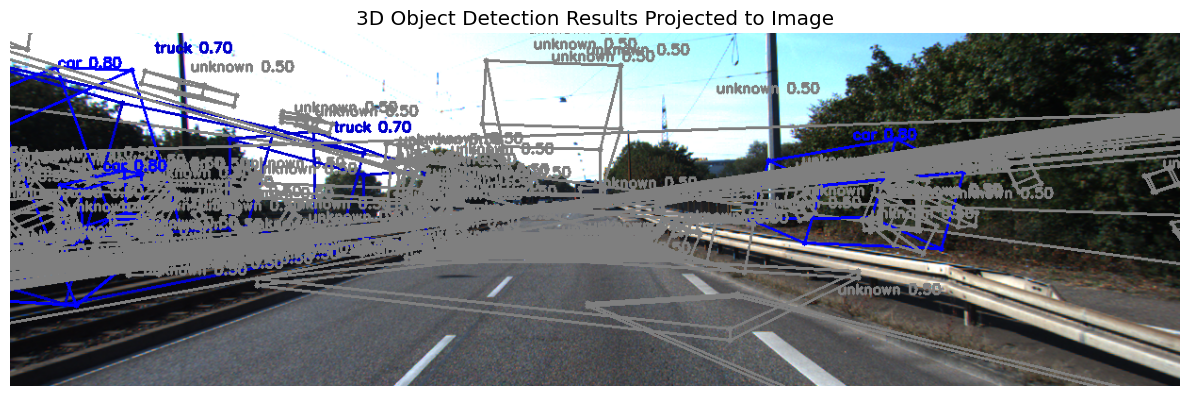

In [20]:
# %%
def project_3d_bbox_to_image(bbox, calib_data):
    """
    3D 바운딩 박스를 이미지 평면에 투영
    
    Args:
        bbox (dict): 3D 바운딩 박스 정보
        calib_data (dict): 캘리브레이션 데이터
        
    Returns:
        numpy.ndarray: 이미지 평면에 투영된 바운딩 박스 코너 [8, 2]
    """
    center = bbox['center']
    dimensions = bbox['dimensions']
    
    # 박스의 8개 코너 계산
    l, w, h = dimensions
    
    # 방향성 바운딩 박스인 경우
    if 'rotation_matrix' in bbox:
        R = bbox['rotation_matrix']
    else:
        # 축 정렬 바운딩 박스인 경우
        R = np.eye(3)
    
    # 로컬 좌표계에서 코너 계산
    corners_local = np.array([
        [ l/2,  w/2,  h/2],  # 0: 오른쪽 위 앞
        [ l/2, -w/2,  h/2],  # 1: 왼쪽 위 앞
        [-l/2, -w/2,  h/2],  # 2: 왼쪽 위 뒤
        [-l/2,  w/2,  h/2],  # 3: 오른쪽 위 뒤
        [ l/2,  w/2, -h/2],  # 4: 오른쪽 아래 앞
        [ l/2, -w/2, -h/2],  # 5: 왼쪽 아래 앞
        [-l/2, -w/2, -h/2],  # 6: 왼쪽 아래 뒤
        [-l/2,  w/2, -h/2]   # 7: 오른쪽 아래 뒤
    ])
    
    # 회전 및 이동 적용
    corners_global = np.dot(corners_local, R.T) + center
    
    # LiDAR 좌표계에서 카메라 좌표계로 변환
    corners_cam = lidar_to_camera(corners_global, calib_data)
    
    # 카메라 좌표계에서 이미지 평면으로 투영
    corners_img = camera_to_image(corners_cam, calib_data)
    
    return corners_img

def draw_3d_bbox_on_image(image, corners_img, color=(0, 255, 0), thickness=2, draw_lines=True):
    """
    이미지에 3D 바운딩 박스 투영 결과 그리기
    
    Args:
        image (numpy.ndarray): 이미지
        corners_img (numpy.ndarray): 투영된 바운딩 박스 코너 [8, 2]
        color (tuple): 색상 (BGR)
        thickness (int): 선 두께
        draw_lines (bool): 코너 연결선 그리기 여부
        
    Returns:
        numpy.ndarray: 바운딩 박스가 그려진 이미지
    """
    img = image.copy()
    
    # 코너 좌표를 정수로 변환
    corners = corners_img.astype(np.int32)
    
    # 코너 그리기
    for corner in corners:
        cv2.circle(img, tuple(corner), 3, color, -1)
    
    if draw_lines:
        # 바닥면 연결
        cv2.line(img, tuple(corners[4]), tuple(corners[5]), color, thickness)
        cv2.line(img, tuple(corners[5]), tuple(corners[6]), color, thickness)
        cv2.line(img, tuple(corners[6]), tuple(corners[7]), color, thickness)
        cv2.line(img, tuple(corners[7]), tuple(corners[4]), color, thickness)
        
        # 천장면 연결
        cv2.line(img, tuple(corners[0]), tuple(corners[1]), color, thickness)
        cv2.line(img, tuple(corners[1]), tuple(corners[2]), color, thickness)
        cv2.line(img, tuple(corners[2]), tuple(corners[3]), color, thickness)
        cv2.line(img, tuple(corners[3]), tuple(corners[0]), color, thickness)
        
        # 기둥 연결
        cv2.line(img, tuple(corners[0]), tuple(corners[4]), color, thickness)
        cv2.line(img, tuple(corners[1]), tuple(corners[5]), color, thickness)
        cv2.line(img, tuple(corners[2]), tuple(corners[6]), color, thickness)
        cv2.line(img, tuple(corners[3]), tuple(corners[7]), color, thickness)
    
    return img

# 객체 검출 결과를 이미지에 투영
projected_results = []

for result in object_results:
    bbox = result['bbox']
    obj_class = result['class']
    confidence = result['confidence']
    
    # 3D 바운딩 박스 이미지 투영
    try:
        corners_img = project_3d_bbox_to_image(bbox, calib_data)
        
        # 투영 결과 저장
        projected_result = {
            'id': result['id'],
            'class': obj_class,
            'confidence': confidence,
            'corners_img': corners_img,
            'bbox': bbox
        }
        
        projected_results.append(projected_result)
    except:
        print(f"객체 {result['id']} 투영 오류 발생")

# 결과 시각화
img_result = image.copy()

for result in projected_results:
    obj_class = result['class']
    confidence = result['confidence']
    corners_img = result['corners_img']
    
    # 클래스별 색상 설정
    color_rgb = class_colors.get(obj_class, [0.5, 0.5, 0.5])
    color_bgr = (int(color_rgb[2]*255), int(color_rgb[1]*255), int(color_rgb[0]*255))
    
    # 바운딩 박스 그리기
    img_result = draw_3d_bbox_on_image(img_result, corners_img, color=color_bgr)
    
    # 레이블 추가
    # 바운딩 박스 중심 계산
    center_x = np.mean(corners_img[:, 0])
    center_y = np.min(corners_img[:, 1])  # 상단
    
    label = f"{obj_class} {confidence:.2f}"
    cv2.putText(img_result, label, (int(center_x), int(center_y)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_bgr, 2)
# 결과 표시
plt.figure(figsize=(12, 8))
plt.imshow(img_result)
plt.title('3D Object Detection Results Projected to Image')
plt.axis('off')
plt.tight_layout()
plt.show()

## 9. 딥러닝 기반 객체 검출

딥러닝 모델을 사용한 포인트 클라우드 기반 객체 검출 방법을 알아봅니다.

In [11]:
# 간단한 PointNet 스타일 네트워크 구현
class SimplePointNet(nn.Module):
    def __init__(self, input_channels=3, num_classes=4):
        super(SimplePointNet, self).__init__()
        
        # 포인트 특징 추출 네트워크
        self.conv1 = nn.Conv1d(input_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        
        # 배치 정규화 레이어
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        # 분류 헤드
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # x: (batch_size, input_channels, num_points)
        
        # 포인트 특징 추출
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        # 글로벌 풀링
        x = torch.max(x, dim=2, keepdim=False)[0]
        
        # 분류
        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

def preprocess_points_for_pointnet(points, num_points=1024):
    """
    포인트 클라우드를 PointNet 입력 형식으로 전처리
    
    Args:
        points (numpy.ndarray): 포인트 클라우드 [N, 3+]
        num_points (int): 샘플링할 포인트 수
        
    Returns:
        numpy.ndarray: 전처리된 포인트 클라우드 [3, num_points]
    """
    # 좌표만 추출
    xyz = points[:, :3]
    
    # 중심 이동
    center = np.mean(xyz, axis=0)
    xyz = xyz - center
    
    # 크기 정규화
    max_dist = np.max(np.sqrt(np.sum(xyz**2, axis=1)))
    xyz = xyz / max_dist
    
    # 포인트 샘플링
    if len(xyz) >= num_points:
        # 무작위 샘플링
        idx = np.random.choice(len(xyz), num_points, replace=False)
    else:
        # 반복 샘플링
        idx = np.random.choice(len(xyz), num_points, replace=True)
    
    xyz_sampled = xyz[idx]
    
    # 차원 변환 (PointNet 입력 형식: [채널, 포인트])
    xyz_sampled = xyz_sampled.T
    
    return xyz_sampled

# 모델 학습 및 평가 함수
def train_and_evaluate_model(clusters, labels, test_size=0.3):
    """
    PointNet 모델 학습 및 평가
    
    Args:
        clusters (list): 클러스터 리스트
        labels (list): 클래스 레이블 리스트
        test_size (float): 테스트 데이터 비율
        
    Returns:
        SimplePointNet: 학습된 모델
    """
    # 클래스 매핑
    class_to_idx = {'car': 0, 'pedestrian': 1, 'cyclist': 2, 'other': 3}
    
    # 레이블 인덱스 변환
    label_indices = [class_to_idx.get(label, 3) for label in labels]
    
    # 데이터 전처리
    processed_data = []
    for cluster in clusters:
        processed = preprocess_points_for_pointnet(cluster)
        processed_data.append(processed)
    
    # 데이터 분할 (학습/테스트)
    n_samples = len(processed_data)
    n_test = int(n_samples * test_size)
    
    # 무작위 인덱스 생성
    indices = np.random.permutation(n_samples)
    test_idx, train_idx = indices[:n_test], indices[n_test:]
    
    # 학습/테스트 데이터 분리
    train_data = [processed_data[i] for i in train_idx]
    train_labels = [label_indices[i] for i in train_idx]
    test_data = [processed_data[i] for i in test_idx]
    test_labels = [label_indices[i] for i in test_idx]
    
    # PyTorch 텐서로 변환
    train_data = torch.FloatTensor(np.array(train_data))
    train_labels = torch.LongTensor(np.array(train_labels))
    test_data = torch.FloatTensor(np.array(test_data))
    test_labels = torch.LongTensor(np.array(test_labels))
    
    # 모델 초기화
    model = SimplePointNet(input_channels=3, num_classes=4)
    
    # 손실 함수 및 옵티마이저
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 학습
    num_epochs = 20
    batch_size = 8
    
    for epoch in range(num_epochs):
        model.train()
        
        # 배치 처리
        for i in range(0, len(train_data), batch_size):
            batch_data = train_data[i:i+batch_size]
            batch_labels = train_labels[i:i+batch_size]
            
            # 순전파
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            
            # 역전파
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # 평가
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_data)
            _, predicted = torch.max(test_outputs, 1)
            accuracy = (predicted == test_labels).sum().item() / len(test_labels)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    # 최종 평가
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted == test_labels).sum().item() / len(test_labels)
    
    print(f"\n최종 테스트 정확도: {accuracy:.4f}")
    
    return model

# 데이터 생성 (학습 시뮬레이션 용)
def create_synthetic_data():
    """
    학습용 합성 데이터 생성
    
    Returns:
        tuple: (클러스터, 레이블)
    """
    synthetic_clusters = []
    synthetic_labels = []
    
    # 차량 데이터 생성
    for _ in range(20):
        # 차량 크기
        l = np.random.uniform(3.5, 5.0)
        w = np.random.uniform(1.5, 2.0)
        h = np.random.uniform(1.4, 1.8)
        
        # 무작위 포인트 생성 (차량 형태)
        num_points = np.random.randint(100, 200)
        x = np.random.uniform(-l/2, l/2, num_points)
        y = np.random.uniform(-w/2, w/2, num_points)
        z = np.random.uniform(-h/2, h/2, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('car')
    
    # 보행자 데이터 생성
    for _ in range(15):
        # 보행자 크기
        w = np.random.uniform(0.4, 0.6)
        d = np.random.uniform(0.4, 0.6)
        h = np.random.uniform(1.5, 1.9)
        
        # 무작위 포인트 생성 (보행자 형태)
        num_points = np.random.randint(50, 100)
        x = np.random.uniform(-w/2, w/2, num_points)
        y = np.random.uniform(-d/2, d/2, num_points)
        z = np.random.uniform(0, h, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('pedestrian')
    
    # 자전거 데이터 생성
    for _ in range(10):
        # 자전거 크기
        l = np.random.uniform(1.5, 2.0)
        w = np.random.uniform(0.5, 0.7)
        h = np.random.uniform(1.2, 1.8)
        
        # 무작위 포인트 생성 (자전거 형태)
        num_points = np.random.randint(70, 150)
        x = np.random.uniform(-l/2, l/2, num_points)
        y = np.random.uniform(-w/2, w/2, num_points)
        z = np.random.uniform(0, h, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('cyclist')
    
    # 기타 객체 데이터 생성
    for _ in range(15):
        # 무작위 크기
        s1 = np.random.uniform(0.5, 2.0)
        s2 = np.random.uniform(0.5, 2.0)
        s3 = np.random.uniform(0.5, 2.0)
        
        # 무작위 포인트 생성 (임의 형태)
        num_points = np.random.randint(30, 100)
        x = np.random.uniform(-s1/2, s1/2, num_points)
        y = np.random.uniform(-s2/2, s2/2, num_points)
        z = np.random.uniform(-s3/2, s3/2, num_points)
        
        points = np.column_stack((x, y, z))
        synthetic_clusters.append(points)
        synthetic_labels.append('other')
    
    return synthetic_clusters, synthetic_labels

# 합성 데이터 생성 및 모델 학습 (시뮬레이션)
try:
    print("합성 데이터로 PointNet 학습 시뮬레이션 (학습 목적)")
    synthetic_clusters, synthetic_labels = create_synthetic_data()
    
    # 학습 데이터 크기
    print(f"합성 데이터 크기: {len(synthetic_clusters)} 객체")
    
    # 클래스별 개수
    class_counts = {}
    for label in synthetic_labels:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    print("클래스별 개수:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")
    
    # 모델 학습 및 평가
    model = train_and_evaluate_model(synthetic_clusters, synthetic_labels)
    
    # 실제 클러스터에 모델 적용 (시뮬레이션)
    print("\n검출된 클러스터에 모델 적용 (시뮬레이션)")
    
    class_idx_to_name = {0: 'car', 1: 'pedestrian', 2: 'cyclist', 3: 'other'}
    
    # 클러스터 전처리 및 예측
    model.eval()
    dl_predictions = []
    
    for i, cluster in enumerate(clusters):
        if len(cluster) < 10:
            continue
            
        # 포인트 전처리
        processed = preprocess_points_for_pointnet(cluster)
        processed_tensor = torch.FloatTensor(processed).unsqueeze(0)  # 배치 차원 추가
        
        # 예측
        with torch.no_grad():
            outputs = model(processed_tensor)
            _, predicted = torch.max(outputs, 1)
            
            pred_idx = predicted.item()
            pred_class = class_idx_to_name[pred_idx]
            confidence = F.softmax(outputs, dim=1)[0, pred_idx].item()
        
        print(f"클러스터 {i}: 예측 클래스={pred_class}, 신뢰도={confidence:.4f}")
        
        # 예측 결과 저장
        dl_predictions.append({
            'id': i,
            'class': pred_class,
            'confidence': confidence,
            'bbox': bboxes[i] if i < len(bboxes) else None
        })
    
    # 규칙 기반과 딥러닝 결과 비교 시각화
    if dl_predictions:
        print("\n규칙 기반 vs. 딥러닝 분류 결과 비교:")
        
        for i, (rule_result, dl_result) in enumerate(zip(object_results, dl_predictions)):
            if i >= len(object_results) or i >= len(dl_predictions):
                break
                
            rule_class = rule_result['class']
            dl_class = dl_result['class']
            
            print(f"객체 {i}: 규칙 기반={rule_class}, 딥러닝={dl_class}")
except Exception as e:
    print(f"딥러닝 모델 학습 및 적용 중 오류 발생: {e}")
    print("실제 환경에서는 사전 학습된 모델 로드가 필요합니다.")

합성 데이터로 PointNet 학습 시뮬레이션 (학습 목적)
합성 데이터 크기: 60 객체
클래스별 개수:
  car: 20
  pedestrian: 15
  cyclist: 10
  other: 15
Epoch 1/20, Loss: 0.9891, Accuracy: 0.2778
Epoch 2/20, Loss: 1.1121, Accuracy: 0.2778
Epoch 3/20, Loss: 1.0326, Accuracy: 0.2778
Epoch 4/20, Loss: 1.1786, Accuracy: 0.5556
Epoch 5/20, Loss: 1.0733, Accuracy: 0.6111
Epoch 6/20, Loss: 1.1744, Accuracy: 0.7222
Epoch 7/20, Loss: 0.8304, Accuracy: 0.8889
Epoch 8/20, Loss: 0.7700, Accuracy: 0.9444
Epoch 9/20, Loss: 0.4002, Accuracy: 0.9444
Epoch 10/20, Loss: 0.4335, Accuracy: 0.9444
Epoch 11/20, Loss: 0.3598, Accuracy: 0.9444
Epoch 12/20, Loss: 0.6519, Accuracy: 0.9444
Epoch 13/20, Loss: 0.4850, Accuracy: 0.9444
Epoch 14/20, Loss: 0.5647, Accuracy: 0.9444
Epoch 15/20, Loss: 0.4076, Accuracy: 0.9444
Epoch 16/20, Loss: 0.2746, Accuracy: 0.9444
Epoch 17/20, Loss: 0.1884, Accuracy: 0.9444
Epoch 18/20, Loss: 0.2601, Accuracy: 0.8889
Epoch 19/20, Loss: 0.2971, Accuracy: 0.8889
Epoch 20/20, Loss: 0.1824, Accuracy: 0.9444

최종 테스트 정확도: 0.9

## 10. 센서 융합 기반 객체 검출

LiDAR와 카메라 데이터를 융합하여 더 정확한 객체 검출을 수행합니다.

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


2D 검출 수: 10
3D 검출 수: 140


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


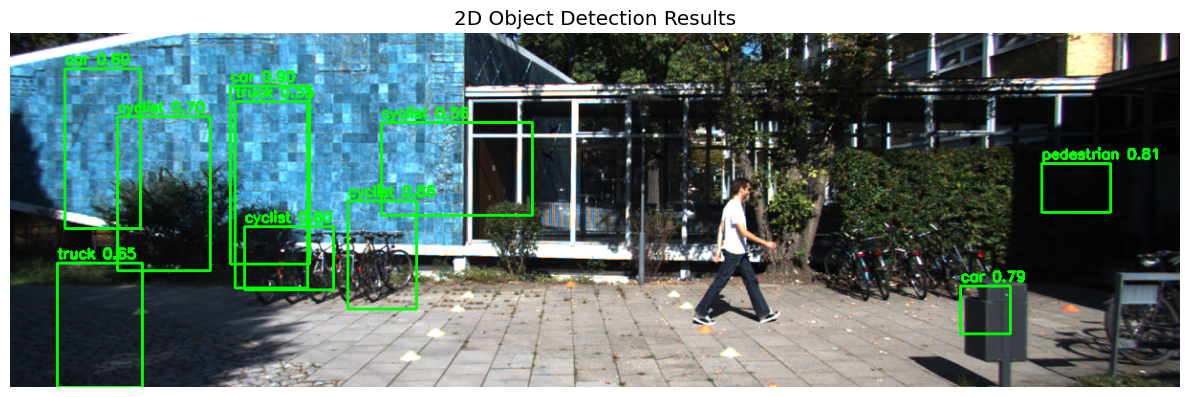

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


융합 검출 수: 81
소스별 검출 수:
  3d: 71
  2d: 10


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.


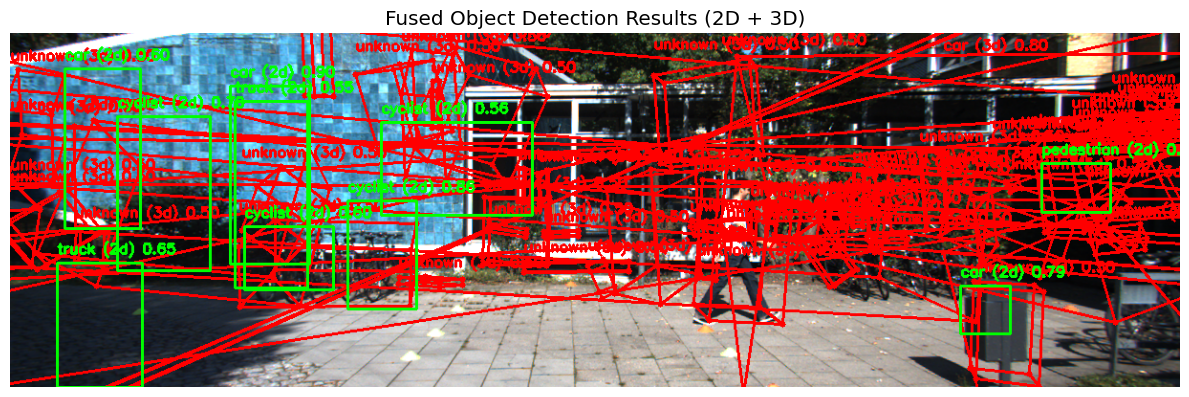

In [12]:
# 이미지 기반 객체 검출 결과 시뮬레이션
def simulate_2d_detection(image):
    """
    2D 객체 검출 결과 시뮬레이션 (실제로는 사전 학습된 모델 사용)
    
    Args:
        image (numpy.ndarray): 입력 이미지
        
    Returns:
        list: 2D 바운딩 박스 리스트 [x_min, y_min, x_max, y_max, class, confidence]
    """
    height, width = image.shape[:2]
    detections_2d = []
    
    # 무작위 박스 생성 (시뮬레이션 목적)
    for _ in range(10):
        # 무작위 바운딩 박스
        x_min = np.random.randint(0, width - 100)
        y_min = np.random.randint(0, height - 100)
        box_w = np.random.randint(50, 200)
        box_h = np.random.randint(50, 200)
        x_max = min(x_min + box_w, width)
        y_max = min(y_min + box_h, height)
        
        # 무작위 클래스 및 신뢰도
        classes = ['car', 'pedestrian', 'cyclist', 'truck']
        class_id = np.random.randint(0, len(classes))
        class_name = classes[class_id]
        confidence = np.random.uniform(0.5, 0.9)
        
        detections_2d.append([x_min, y_min, x_max, y_max, class_name, confidence])
    
    return detections_2d

def fuse_2d_3d_detections(detections_2d, detections_3d, calib_data, image_shape, iou_threshold=0.5):
    """
    2D와 3D 객체 검출 결과 융합
    
    Args:
        detections_2d (list): 2D 검출 결과 [x_min, y_min, x_max, y_max, class, confidence]
        detections_3d (list): 3D 검출 결과 딕셔너리
        calib_data (dict): 캘리브레이션 데이터
        image_shape (tuple): 이미지 크기 (height, width)
        iou_threshold (float): 융합을 위한 IoU 임계값
        
    Returns:
        list: 융합된 검출 결과
    """
    fused_detections = []
    used_2d_indices = set()
    used_3d_indices = set()
    
    # 각 3D 검출을 2D 이미지에 투영
    for i, det_3d in enumerate(detections_3d):
        if 'bbox' not in det_3d:
            continue
            
        # 3D 바운딩 박스 이미지 투영
        try:
            corners_img = project_3d_bbox_to_image(det_3d['bbox'], calib_data)
            
            # 2D 바운딩 박스 계산
            min_x = max(0, int(np.min(corners_img[:, 0])))
            min_y = max(0, int(np.min(corners_img[:, 1])))
            max_x = min(image_shape[1], int(np.max(corners_img[:, 0])))
            max_y = min(image_shape[0], int(np.max(corners_img[:, 1])))
            
            # 유효한 박스 확인
            if max_x <= min_x or max_y <= min_y:
                continue
                
            # 3D 검출의 2D 박스
            box_3d_proj = [min_x, min_y, max_x, max_y]
            
            # 가장 잘 일치하는 2D 검출 찾기
            best_iou = 0
            best_match = -1
            
            for j, det_2d in enumerate(detections_2d):
                box_2d = det_2d[:4]
                
                # IoU 계산
                iou = calculate_iou(box_3d_proj, box_2d)
                
                if iou > best_iou:
                    best_iou = iou
                    best_match = j
            
            # 충분히 일치하는 2D 검출이 있으면 융합
            if best_iou > iou_threshold:
                det_2d = detections_2d[best_match]
                
                # 클래스가 일치하는지 확인
                class_3d = det_3d['class']
                class_2d = det_2d[4]
                
                # 클래스가 일치하거나 유사하면 가중치 증가
                class_weight_3d = 0.6  # 기본 3D 가중치
                class_weight_2d = 0.4  # 기본 2D 가중치
                
                if class_3d == class_2d:
                    class_weight_3d = 0.5
                    class_weight_2d = 0.5
                elif (class_3d == 'car' and class_2d == 'truck') or (class_3d == 'truck' and class_2d == 'car'):
                    class_weight_3d = 0.5
                    class_weight_2d = 0.5
                
                # 클래스가 다른 경우, 신뢰도 비교하여 선택
                if class_3d != class_2d:
                    if det_3d['confidence'] > det_2d[5]:
                        final_class = class_3d
                    else:
                        final_class = class_2d
                else:
                    final_class = class_3d
                
                # 3D 위치와 크기 정보
                position_3d = det_3d['center']
                dimensions_3d = det_3d['dimensions']
                
                # 2D 박스 정보
                box_2d = det_2d[:4]
                
                # 신뢰도 가중 평균
                confidence = class_weight_3d * det_3d['confidence'] + class_weight_2d * det_2d[5]
                
                # 융합 결과 저장
                fused_det = {
                    'id': len(fused_detections),
                    'class': final_class,
                    'confidence': confidence,
                    'position_3d': position_3d,
                    'dimensions_3d': dimensions_3d,
                    'box_2d': box_2d,
                    'box_3d_proj': box_3d_proj,
                    'corners_img': corners_img,
                    'source': 'fusion'
                }
                
                fused_detections.append(fused_det)
                used_2d_indices.add(best_match)
                used_3d_indices.add(i)
            else:
                # 일치하는 2D 검출이 없으면 3D 검출만 추가
                fused_det = {
                    'id': len(fused_detections),
                    'class': det_3d['class'],
                    'confidence': det_3d['confidence'],
                    'position_3d': det_3d['center'],
                    'dimensions_3d': det_3d['dimensions'],
                    'box_3d_proj': box_3d_proj,
                    'corners_img': corners_img,
                    'source': '3d'
                }
                
                fused_detections.append(fused_det)
                used_3d_indices.add(i)
        except:
            print(f"3D 객체 {i} 투영 오류 발생")
    
    # 매칭되지 않은 2D 검출 추가
    for i, det_2d in enumerate(detections_2d):
        if i not in used_2d_indices:
            box_2d = det_2d[:4]
            class_name = det_2d[4]
            confidence = det_2d[5]
            
            fused_det = {
                'id': len(fused_detections),
                'class': class_name,
                'confidence': confidence,
                'box_2d': box_2d,
                'source': '2d'
            }
            
            fused_detections.append(fused_det)
    
    return fused_detections

def calculate_iou(box1, box2):
    """
    두 2D 바운딩 박스 간의 IoU 계산
    
    Args:
        box1 (list): 첫 번째 바운딩 박스 [x_min, y_min, x_max, y_max]
        box2 (list): 두 번째 바운딩 박스 [x_min, y_min, x_max, y_max]
        
    Returns:
        float: IoU 값
    """
    # 교차 영역 계산
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # 각 박스 영역 계산
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # IoU 계산
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

def visualize_fusion_results(image, fused_detections):
    """
    융합 검출 결과 시각화
    
    Args:
        image (numpy.ndarray): 입력 이미지
        fused_detections (list): 융합된 검출 결과
        
    Returns:
        numpy.ndarray: 결과 이미지
    """
    img_result = image.copy()
    
    # 소스별 색상 정의
    source_colors = {
        'fusion': (0, 255, 255),  # 노랑 (융합)
        '3d': (255, 0, 0),      # 빨강 (3D)
        '2d': (0, 255, 0)       # 초록 (2D)
    }
    
    for det in fused_detections:
        source = det['source']
        class_name = det['class']
        confidence = det['confidence']
        
        # 색상 설정
        color = source_colors.get(source, (255, 255, 255))
        
        # 2D 바운딩 박스 그리기
        if 'box_2d' in det:
            box = det['box_2d']
            cv2.rectangle(img_result, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        
        # 3D 바운딩 박스 그리기
        if 'corners_img' in det:
            corners = det['corners_img']
            img_result = draw_3d_bbox_on_image(img_result, corners, color=color)
        
        # 레이블 추가
        if 'box_2d' in det:
            label_x, label_y = int(det['box_2d'][0]), int(det['box_2d'][1] - 10)
        elif 'box_3d_proj' in det:
            label_x, label_y = int(det['box_3d_proj'][0]), int(det['box_3d_proj'][1] - 10)
        else:
            continue
            
        label = f"{class_name} ({source}) {confidence:.2f}"
        cv2.putText(img_result, label, (label_x, label_y), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return img_result

# 2D 객체 검출 시뮬레이션
detections_2d = simulate_2d_detection(image)

print(f"2D 검출 수: {len(detections_2d)}")
print(f"3D 검출 수: {len(object_results)}")

# 2D 검출 결과 시각화
img_2d = image.copy()
for det in detections_2d:
    x_min, y_min, x_max, y_max, class_name, confidence = det
    cv2.rectangle(img_2d, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    label = f"{class_name} {confidence:.2f}"
    cv2.putText(img_2d, label, (x_min, y_min-5), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(img_2d)
plt.title('2D Object Detection Results')
plt.axis('off')
plt.tight_layout()
plt.show()

# 2D와 3D 검출 결과 융합
fused_detections = fuse_2d_3d_detections(detections_2d, object_results, calib_data, image.shape[:2])

print(f"융합 검출 수: {len(fused_detections)}")
print("소스별 검출 수:")
sources = {}
for det in fused_detections:
    sources[det['source']] = sources.get(det['source'], 0) + 1
for source, count in sources.items():
    print(f"  {source}: {count}")

# 융합 결과 시각화
img_fusion = visualize_fusion_results(image, fused_detections)

plt.figure(figsize=(12, 8))
plt.imshow(img_fusion)
plt.title('Fused Object Detection Results (2D + 3D)')
plt.axis('off')
plt.tight_layout()
plt.show()


## 11. 객체 검출 성능 평가

객체 검출 알고리즘의 성능을 평가하는 방법과 지표에 대해 알아봅니다.

In [13]:
def calculate_precision_recall(detections, ground_truth, iou_threshold=0.5):
    """
    정밀도와 재현율 계산
    
    Args:
        detections (list): 검출 결과 리스트
        ground_truth (list): 실제 정답 리스트
        iou_threshold (float): IoU 임계값
        
    Returns:
        tuple: (정밀도, 재현율, F1 점수)
    """
    # 일치 여부 저장
    matched_detections = [False] * len(detections)
    matched_gt = [False] * len(ground_truth)
    
    # 각 GT 객체에 대해 매칭되는 검출 찾기
    for i, gt in enumerate(ground_truth):
        best_iou = 0
        best_match = -1
        
        gt_box = gt['box']
        gt_class = gt['class']
        
        for j, det in enumerate(detections):
            if matched_detections[j]:
                continue
                
            det_box = det['box']
            det_class = det['class']
            
            # 같은 클래스인 경우만 매칭
            if gt_class != det_class:
                continue
                
            # IoU 계산
            iou = calculate_iou(gt_box, det_box)
            
            if iou > best_iou:
                best_iou = iou
                best_match = j
        
        # IoU가 임계값 이상인 경우 매칭
        if best_iou >= iou_threshold:
            matched_detections[best_match] = True
            matched_gt[i] = True
    
    # TP, FP, FN 계산
    TP = sum(matched_detections)
    FP = len(detections) - TP
    FN = len(ground_truth) - sum(matched_gt)
    
    # 정밀도, 재현율, F1 점수 계산
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def calculate_map(detections, ground_truth, iou_thresholds=[0.5]):
    """
    mAP(mean Average Precision) 계산
    
    Args:
        detections (list): 검출 결과 리스트
        ground_truth (list): 실제 정답 리스트
        iou_thresholds (list): IoU 임계값 리스트
        
    Returns:
        float: mAP 값
    """
    aps = []
    
    # 각 IoU 임계값에 대해 AP 계산
    for iou_threshold in iou_thresholds:
        precision, recall, _ = calculate_precision_recall(detections, ground_truth, iou_threshold)
        aps.append(precision * recall)  # 간단한 AP 계산 (정밀도 * 재현율)
    
    # mAP 계산
    mAP = sum(aps) / len(aps)
    
    return mAP

# 예시 정답 데이터 생성 (시뮬레이션 용)
def generate_sample_ground_truth():
    """
    예시 정답 데이터 생성
    
    Returns:
        list: 정답 데이터 리스트
    """
    ground_truth = []
    
    # 자동차 1
    ground_truth.append({
        'id': 0,
        'class': 'car',
        'box': [100, 150, 250, 250]  # [x_min, y_min, x_max, y_max]
    })
    
    # 자동차 2
    ground_truth.append({
        'id': 1,
        'class': 'car',
        'box': [400, 200, 550, 300]
    })
    
    # 보행자
    ground_truth.append({
        'id': 2,
        'class': 'pedestrian',
        'box': [300, 100, 350, 250]
    })
    
    # 자전거
    ground_truth.append({
        'id': 3,
        'class': 'cyclist',
        'box': [600, 150, 680, 250]
    })
    
    return ground_truth

# 예시 검출 결과 생성 (시뮬레이션 용)
def generate_sample_detections():
    """
    예시 검출 결과 생성
    
    Returns:
        list: 검출 결과 리스트
    """
    detections = []
    
    # 자동차 1 (정확한 검출)
    detections.append({
        'id': 0,
        'class': 'car',
        'confidence': 0.85,
        'box': [105, 155, 255, 255]
    })
    
    # 자동차 2 (약간 부정확한 검출)
    detections.append({
        'id': 1,
        'class': 'car',
        'confidence': 0.75,
        'box': [410, 210, 540, 290]
    })
    
    # 보행자 (부정확한 클래스)
    detections.append({
        'id': 2,
        'class': 'pedestrian',
        'confidence': 0.65,
        'box': [310, 110, 360, 240]
    })
    
    # 오검출 (없는 객체)
    detections.append({
        'id': 3,
        'class': 'car',
        'confidence': 0.55,
        'box': [500, 300, 600, 380]
    })
    
    # 미검출 (자전거 누락)
    
    return detections

# 성능 평가 시뮬레이션
ground_truth = generate_sample_ground_truth()
detections = generate_sample_detections()

print("성능 평가 시뮬레이션:")
print(f"정답 객체 수: {len(ground_truth)}")
print(f"검출 객체 수: {len(detections)}")

# 정밀도, 재현율, F1 점수 계산
precision, recall, f1 = calculate_precision_recall(detections, ground_truth)
print(f"정밀도: {precision:.4f}")
print(f"재현율: {recall:.4f}")
print(f"F1 점수: {f1:.4f}")

# mAP 계산
mAP = calculate_map(detections, ground_truth, iou_thresholds=[0.5, 0.7])
print(f"mAP: {mAP:.4f}")

# 클래스별 성능 평가
classes = ['car', 'pedestrian', 'cyclist']
print("\n클래스별 성능:")

for cls in classes:
    # 클래스별 필터링
    cls_gt = [gt for gt in ground_truth if gt['class'] == cls]
    cls_det = [det for det in detections if det['class'] == cls]
    
    if len(cls_gt) > 0:
        precision, recall, f1 = calculate_precision_recall(cls_det, cls_gt)
        print(f"{cls}:")
        print(f"  - 정답 객체 수: {len(cls_gt)}")
        print(f"  - 검출 객체 수: {len(cls_det)}")
        print(f"  - 정밀도: {precision:.4f}")
        print(f"  - 재현율: {recall:.4f}")
        print(f"  - F1 점수: {f1:.4f}")

성능 평가 시뮬레이션:
정답 객체 수: 4
검출 객체 수: 4
정밀도: 0.7500
재현율: 0.7500
F1 점수: 0.7500
mAP: 0.3125

클래스별 성능:
car:
  - 정답 객체 수: 2
  - 검출 객체 수: 3
  - 정밀도: 0.6667
  - 재현율: 1.0000
  - F1 점수: 0.8000
pedestrian:
  - 정답 객체 수: 1
  - 검출 객체 수: 1
  - 정밀도: 1.0000
  - 재현율: 1.0000
  - F1 점수: 1.0000
cyclist:
  - 정답 객체 수: 1
  - 검출 객체 수: 0
  - 정밀도: 0.0000
  - 재현율: 0.0000
  - F1 점수: 0.0000


## 12. 요약 및 결론

이 노트북에서는 자율주행을 위한 다양한 객체 검출 방법을 살펴보고 구현해 보았습니다.

주요 학습 내용:

1. 객체 검출의 기본 개념과 접근 방식
2. 지면 검출 및 제거를 통한 전처리
3. 포인트 클라우드 클러스터링을 통한 객체 후보 검출
4. 3D 바운딩 박스 생성 및 처리
5. 기하학적 특징을 활용한 객체 분류
6. 3D 바운딩 박스의 이미지 투영
7. 딥러닝 기반 포인트 클라우드 객체 검출 방법
8. 2D와 3D 검출 결과 융합
9. 객체 검출 성능 평가 방법

객체 검출은 자율주행 시스템의 인지 단계에서 가장 중요한 작업 중 하나입니다. 정확한 객체 검출을 통해 주변 환경을 이해하고 안전한 주행 계획을 수립할 수 있습니다.

## 다음 단계

- 고급 딥러닝 기반 3D 객체 검출 모델 구현 (PointPillars, SECOND, VoxelNet 등)
- 다양한 센서 융합 기법 연구 (Early/Mid/Late Fusion)
- 시간적 정보를 활용한 객체 추적 구현
- 실시간 성능 최적화 기법 연구
- 다양한 환경 조건에서의 강인성 향상